<img src="./img/HWNI_logo.svg"/>

# Tutorial - Clustering

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import util.plots as plots
import util.em as em
import util.shared as shared

data1d = np.load('./data/data1d.npz')['data'] #problem 1

data2d = np.load('./data/data2d.npz') #problems 2 and 3
datasets = [data2d['mog'],data2d['X'],data2d['O'],]

shared.format_plots()

## Introduction - Hidden Variable Problems

In the datasets we've modeled so far, we've been given paired inputs and outputs -- continuous outputs in regression models, discrete outputs in classification models. Our goal has been to learn to model the relationship between those inputs and outputs. We begin in a particular state of ignorance: we presume that inputs are being transformed into outputs, but we have no idea what kind of transformation is happening. Metaphorically, we represent our state of ignorance by drawing the inputs passing through a "black box" on the way to becoming ouputs.

In this kind of modeling, we often aim to "open the black box" -- to peer inside and determine just exactly how the inputs are being transformed. To approach this modeling problem statistically is to give up on physically opening the box. Instead, we aim to design our own box, hopefully transparent, in such a way that the outputs generated by the box we design and, hopefully, understand are indistinguishable from the outputs of the original, opaque box.

![Supervised Models](./img/supervised.png)

![Modeling](./img/modeling.png)

But the data we wish to model isn't always a simple input-output relationship. Sometimes, we have a collection of observations that we'd like to be able to *describe simply*. We'd like to be able to extract the structure of this data -- to break multidimensional data down into a number of straightforwardly-interacting, simpler components.

To make use of our black box metaphor, we need to rethink the location of our data in our picture. Instead of sitting astride the black box, our data now comes out of the black box. Our goal in statistical modeling is to again design our own, hopefully less opaque, box, which we can then use to generate data that looks as much like the data we actually observed as possible.

![One View of Unsupervised Models](./img/unsupervised-1.png)

Notice that the inputs to this model are unobserved. Unobserved variables are also called *hidden variables*. The discovery that neurotransmitter release is quantal, which earned Bernard Katz a
[a Nobel prize](https://www.nobelprize.org/nobel_prizes/medicine/laureates/1970/speedread.html),
used just such
[a hidden variable model](http://charlesfrye.github.io/stats/2017/11/03/quantal-release-probabilistic-models.html),
where the unobserved variable was the number of vesicles released.

In this way of thinking, the problem we're solving is called  *generative modeling* -- we want to make a model that can create, or generate, convincing data. 

There's another way of adapting the black box metaphor to our new problem, drawn below:

![Another View of Unsupervised Models](./img/unsupervised-2.png)

Here, instead of viewing the data as the output of a black box whose inputs we don't know, we instead view the data as the input to a model whose outputs we don't know. Thus, when our model makes a guess as to what the output for the current input should be, there's not a directly provided "correct" output for it to compare against. The model must learn without "supervision" in the form of being told the correct answers. For this reason, these models are called *unsupervised* models, and fitting them to data called *unsupervised learning*. The models we've considered up to this point were *supervised* models.

It should come as no surprise (especially to anyone who has attended graduate school) that unsupervised learning is harder than supervised learning.

In fact, we can connect the first way we wrote down the problem, thinking in terms of generative models, to one of the main problems that an organism's brain has to solve, perception. Let's relabel the components of our visualization:

![Perception as a Hidden Variable Problem](./img/perception-as-inference.png)

In this view, the organism has access only to sensory data: air pressure waveforms from the ears, patterns of light from the eyes, and so on. But what the organism actually cares about are the causes of that sensory data: predators, prey, objects in the world. These causes give rise to the sensory data through processes in the world, mainly physical processes like the reflection, scattering, and refraction of light or sound waves, the binding and unbinding of chemicals in the olfactory system, and so on.

Figuring out an algorithm to solve perception is clearly an unsolved problem - some might say unsolvable - so we'll stick to a simpler case, where more progess has been made. 

## Clustering as a Hidden Variable Problem

Clustering is the unsupervised counterpart to classification. Recall that in a classification model, we try to map continuous inputs to discrete outputs. The inputs and outputs are paired for us.

Say we collected some labeled data to train a classifier. We might plot it like so, using color to indicate label:

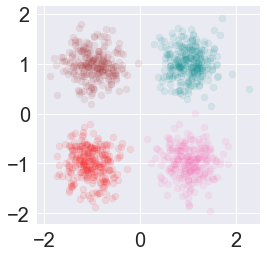

In [2]:
plots.plot_observed_mix(datasets[0],[],[],contours=False);

Imagine that we come back to our computer to find that we accidentally deleted the label file. If we plotted the data, it might look like this:

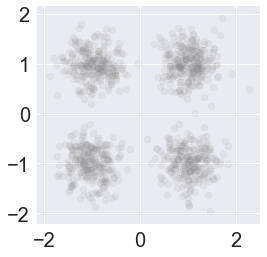

In [3]:
plots.plot_unobserved_mix(datasets[0]);

We'd like to be able to "re-label" this data. A human wouldn't have too much trouble, even if they'd never seen the original data -- it'd just take awhile, as they painstakingly relabeled the data, point by point. We'd like to find an algorithm to perform this labeling for us. We'd also like it to extend to cases where the number of dimensions is too large for a human to visualize, and to cases where the answers aren't so clear, like the one below:

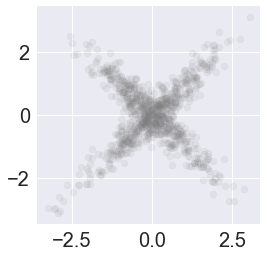

In [4]:
plots.plot_unobserved_mix(datasets[1])

For the purposes of this lab, we'll focus on clustering problems where the individual clusters are shaped like a Gaussian distribution: round or ellipsoid. We do this because the general problem of clustering, where the clusters might have any shape, is (mostly) unsolved. For an example, see below:

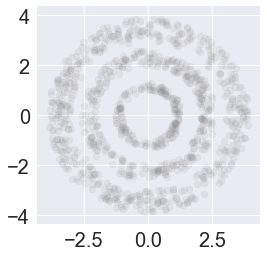

In [5]:
plots.plot_unobserved_mix(datasets[2])

### Breaking Down the Problem of Clustering

First, let's look at our clustering problem using a black box diagram.

![Clustering](./img/clustering.png)

As written, this isn't a problem we know how to solve. But what if we knew which data points came from which clusters? Then our problem would look like the following:

![If clusters were known](./img/known-cluster.png)

This looks just like a supervised problem! And to be sure, if we only had those pesky cluster labels, we could use our supervised learning techniques to figure out what each cluster looked like. We'd posit a family of models, pick some random starting parameters, and then perform gradient descent on the likelihood function  to find the likeliest model.

But we don't have the cluster labels. Let's consider what the problem would look like if we knew the structure of the clusters -- if we had a model that related cluster labels to possible data values:

![If We Knew the Cluster Structure](./img/known-structure.png)

This is also a solvable problem. We can use the laws of probability, namely [Bayes' Rule](http://charlesfrye.github.io/stats/2016/02/04/bayes-rule.html), to figure out what the cluster labels are likely to be. In this form, we have essentially the same problem as we have when we're applying a previously fit classification model to new, unlabeled data. That is, we have a known classification model and we've observed some data points without their cluster labels (the arrows are just reversed).

But we don't know the correct model (that is, we don't know what the clusters look like) and we don't know the correct labels (otherwise we'd be doing supervised learning). So what do we do?

### Solving Clustering By Making Stuff Up

We simply make something up. We pick a set of model parameters at random and treat them *as though they were the true model*. That means we're looking at the third of the three diagrams in the section above. Then, even though we know the model is wrong, we use it to assign labels to the datapoints.

But we don't stop there. Instead, we use these newfound labels to *update the model according to maximum likelihood*. Importantly, just because a set of labels were the most probable labels under a given model doesn't mean that another model wouldn't assign an even higher likelihood to those points.

We iterate this procedure, updating the model and re-assigning the labels, until the parameters and the labels stop changing.

To see this process in action, check out [this animation](https://upload.wikimedia.org/wikipedia/commons/6/69/EM_Clustering_of_Old_Faithful_data.gif) from Wikipedia.

### Simple(ish) Example: K-Means Clustering

We'll start with the simplest version of this procedure. We first assume that the clusters are, speaking roughly, round. Under this assumption, the further a point is from the center (aka mean) of the cluster, the less likely it is to have come from the cluster. If we want to know which point a cluster was most likely to come from, we simply look for the closest cluster mean.

We begin by randomly guessing the locations of the $K$ different cluster means. Then, we assign each data point to a cluster based on which mean is closest. Finally, we set the value of each cluster mean to the mean of the points that were assigned to it. Lather, rinse, repeat.

This algorithm is called $K$-means clustering. The cells below will run it$^\dagger$. 

The first one sets the algorithm up. We choose the dataset to fit, the value of $K$, and the initial values of the cluster means. 

The second one runs the update label-update parameter loop `num_iters` times. If you want to see the initial state, set `num_iters` to 0. This cell can be run repeatedly to update the same model.

As a warning, K-means can be unstable, and this implementation particularly so, so sometimes there will be numerical errors. Just restart from a new initialization if this occurs.

<sub>$\dagger$ Technically, an approximation to $K$-means, not exactly the same algorithm. The behavior is similar.

In [6]:
# run this block once per fit to set parameters

#which dataset?
dataset_idx = 0
dataset = datasets[dataset_idx][:,:-1]

K = 4#YOUR CODE HERE #how many clusters?

parameters, update_sigma, update_w = em.setup_K_means(K)

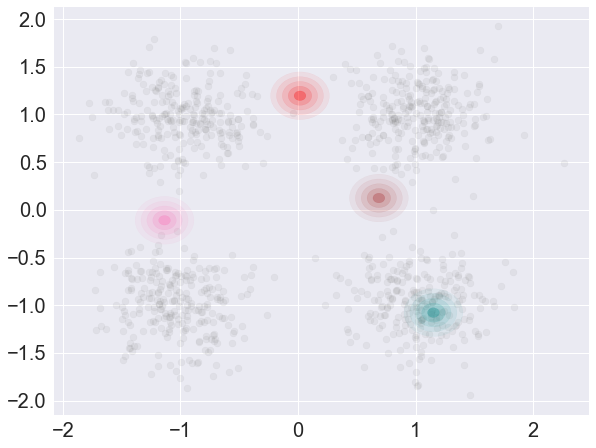

In [7]:
# run this block to fit the model -- can be run multiple times per fit

num_iters = 1

for _ in range(num_iters):
    posteriors, new_parameters = em.run_EM(dataset, parameters,
                                          update_sigma,
                                          update_w)

plots.plot_EM_results(dataset, K, new_parameters)

Start with the first dataset, the one at index `0`. By eye, how many clusters do you see? Set `K` to this value and run the algorithm. Barring instances when you get errors, do you always get a sensible answer?

If you look at the original version of this dataset, you can see that the mixtures were colored brown, blue, pink, and red, going clockwise from the top left. Do the colors match in the solution you find? Do the colors match from run to run?

Try changing `K` to values other than the correct value. What happens to the results when `K` is too small? Too big?

Check out the other clustering datasets (set `dataset_idx` equal to `1` and `2`). Does the $K$-means work as well, better, or worse on these datasets?

### Less Simple Example: Gaussian Mixture Clustering with Expectation-Maximization

$K$-means is a decent first pass, but we can do better.

Above, we assumed that the clusters were described by one parameter, their center, and that the chance of a point coming from a cluster fell off like the distance from the cluster. That is equivalent to assuming that the points in a given cluster are *isotropic multivariate Gaussian* in distribution.

A multivariate Gaussian distribution is just the distribution corresponding to multiple Gaussian-distributed random variables that may or may not be correlated.

Just like univariate, or one-dimensional, Gaussians, multivariate Gaussians usually have two parameters: their mean vector and their covariance matrix. The covariance matrix expresses how much two components of the multivariate Gaussian tend to vary in the same direction relative to their mean, or *co-vary*. When all of the components are independent -- so they don't co-vary at all -- then we say the Gaussian is *isotropic*.

To say something is *isotropic* is to say that it has the same value when measured in different directions. An isotropic Gaussian assigns the same probability to all points that are at the same distance away from it. This lets us use distance as a proxy for computing the probability, as we did in the $K$-means algorithm.

The natural step up from $K$-means is to keep the assumption that each cluster is Gaussian in distribution, but to drop the assumption that the clusters are isotropic. Now, in addition to figuring out the location of the center of the cluster, we need to figure out the covariance matrix of each cluster as well. 

Conveniently, the maximum likelihood estimate for the covariance of some Gaussian-distributed random variables based on data is the covariance of that data, so we can do estimate the covariance the same way we estimated the mean in $K$-means: take the covariance of all of the datapoints assigned to a given cluster as the covariance of that cluster.

We can make one last improvement to $K$-means. Previously, when we assigned points to cluster, we made a "hard assignment": if a point had a 51% chance of coming from cluster A and a 49% chance of coming from cluster B, we assigned it to cluster A. In retrospect, this seems silly: shouldn't we assign a point like that *partially* to cluster A and *partially* to cluster B? We can do this by changing our hard assignments to "soft assignments" -- each point is in every cluster, but with a weight given by the probability that the data point came from that cluster.

So instead of estimating the mean of the cluster as the average position of the points in the cluster, we compute the mean as the *weighted average* position of the points in the cluster. A similar argument lets us compute the weighted average for the covariance. Looking back, we can see the $K$-means calculaiton as a weighted average where all the weights are 1 and 0.

Because we are modeling the clusters using Gaussians, this is an example of Gaussian clustering. Because the overall distribution of the data is a mixture of the Gaussian distribution of each cluster, the data model is a *Gaussian mixture* model, and this is *Gaussian mixture clustering*. The alternating algorithm -- switching between updating parameters and updating weights -- is called the *expectation-maximization* or *EM* algorithm in this context.

The code cells below run the EM algorithm on our datasets.

In [8]:
# run this block once per fit to set parameters

#which dataset?
dataset_idx = 0
dataset = datasets[dataset_idx][:,:-1]

K = 4 #how many components?

parameters = em.make_params(K, #how many components?
                             
                             #means are drawn uniformly from a square centered at 0
                             mu_spread=0.01, #how big should that square be?
                             
                             #covariance matrices are scaled identity matrix
                             sigma_width=0.1 #what should that scaling factor be?
                                 # make it small to approximate K-Means
                            )
    
update_sigma = True
update_w = True

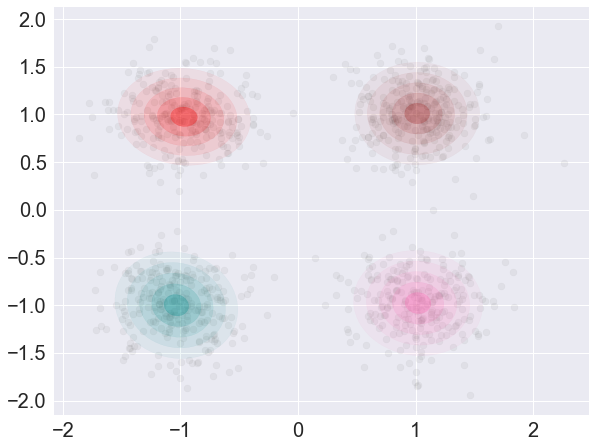

In [9]:
#how many times do we run the updates each time we run the cell?
# set to 1 and run this block repeatedly 
# if you want to watch the fit step-by-step
num_iters = 10

for _ in range(num_iters):
    posteriors,new_parameters = em.run_EM(dataset,parameters,
                                          update_sigma,
                                          update_w)

plots.plot_EM_results(dataset,K,new_parameters)

Starting with the four-circles dataset at index 0, observe the behavior of the expectation-maximization algorithm. Do we consistently get the correct answer when `K` is at the right value? Do we *always* get the correct answer when `K` is at the right value?

Try the mixture at index 1, the "X", many times, with `K=2`. Does it ever work?

Change `mu_spread`, the hyperparameter that determines how wide of range the randomly-generated means have, to a small value. Does this change the chance of success? Why is it a bad thing that the outputs depend so strongly on a hyperparameter?

Try `K=4`. Are the results generally reasonable models of the data? Do they seem to be the "true" cluster assignment of the data?

Run EM on the dataset at index 2, the "bull's eye". Do we get a reasonable model?

Set `K` to a large value, 50 or more, and run again. Does EM recover the structure of the data? If not, what does it do?

### Caveats

Most of the issues with these clustering methods should be obvious from trying the method on the data above: clustering models are very prone to local minima and sensitive to hyperparameters, like the number of clusters and the initialization procedure. It's also very difficult to identify the "true" model, even when the model is doing well on the cost function.

The good news is that the method of making stuff up, then alternating updating labels and updating parameters isn't limited to just the Gaussian mixture case -- it can be applied to the general problem of unsupervised learning or hidden variable inference. Unfortunately, it takes a very long time to run on complicated datasets, like the high definition images our eyes collect, and to discover hierarchical structure in hidden variables, like the presence of a tiger leads to the presence of stripes leads to a particular pattern of light intensities. There's ongoing research on speeding these algorithms up.